# Introduction

Notebook to aggregate the running of models in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Union Strategy

In [2]:
models_runner_1 = Feat_BR_Models_Runner()

lsi_model_1 = models_runner_1.run_lsi_model()
lda_model_1 = models_runner_1.run_lda_model()
bm25_model_1 = models_runner_1.run_bm25_model()
w2v_model_1 = models_runner_1.run_word2vec_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)

Features.shape: (21, 8)
SelectedBugReports.shape: (93, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix UNION.shape: (93, 21)


In [3]:
lsi_eval_1 = evaluator_1.run_evaluator(model=lsi_model_1)
lda_eval_1 = evaluator_1.run_evaluator(model=lda_model_1)
bm25_eval_1 = evaluator_1.run_evaluator(model=bm25_model_1)
w2v_eval_1 = evaluator_1.run_evaluator(model=w2v_model_1)

### Results

In [4]:
evaluator_1.get_evaluations_df()

,model,ref_name,perc_precision,perc_recall,perc_fscore
0,lsi,top_1_cosine_0.0,43.01,31.23,34.49
1,lsi,top_3_cosine_0.0,26.52,52.76,33.36
2,lsi,top_5_cosine_0.0,18.28,58.63,26.44
3,lsi,top_10_cosine_0.0,11.40,71.04,18.78
4,lda,top_1_cosine_0.0,41.94,29.44,32.88
5,lda,top_3_cosine_0.0,20.43,41.08,25.60
6,lda,top_5_cosine_0.0,15.70,50.39,22.57
7,lda,top_10_cosine_0.0,11.40,69.54,18.73
8,bm25,top_1_cosine_0.0,36.56,25.80,28.68
9,bm25,top_3_cosine_0.0,24.01,48.42,30.42


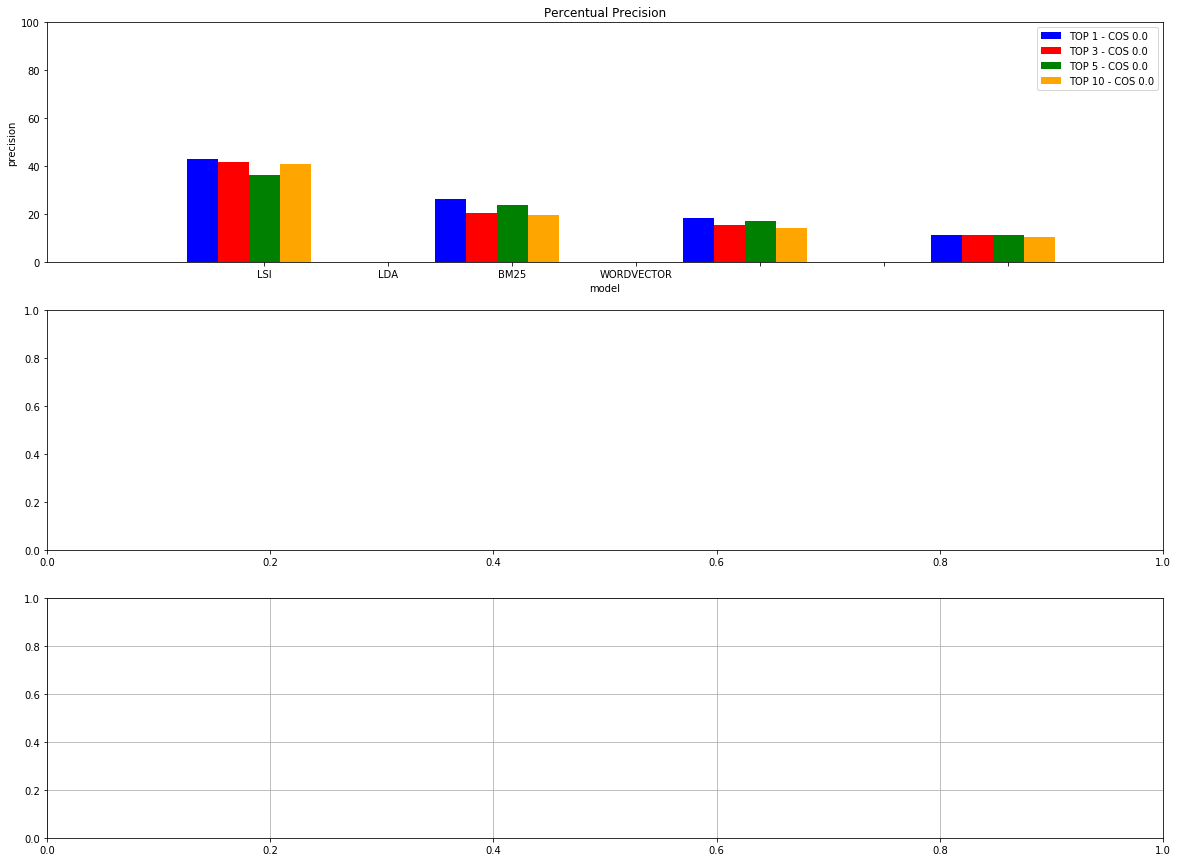

In [50]:
from matplotlib import pyplot as plt
import math
title = ''
results = evaluator_1.get_evaluations_df()

start_pos = 0.25
pos_1 = list([start_pos,         start_pos+2,         start_pos+4,         start_pos+6]) 
pos_2 = list([start_pos+width,   start_pos+2+width,   start_pos+4+width,   start_pos+6+width]) 
pos_3 = list([start_pos+2*width, start_pos+2+2*width, start_pos+4+2*width, start_pos+6+2*width]) 
pos_4 = list([start_pos+3*width, start_pos+2+3*width, start_pos+4+3*width, start_pos+6+3*width]) 
width = 0.25 

min_pos = math.floor(min(pos_1))
max_pos = math.ceil(max(pos_4))                

f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,15))
f.suptitle(title)

model_names = [m.upper() for m in results.model.unique()]

ax1.set_title('Percentual Precision')
ax1.bar(pos_1, width=width, height=results[results.model == 'lsi'].perc_precision.values, color='blue')
ax1.bar(pos_2, width=width, height=results[results.model == 'lda'].perc_precision.values, color='red')
ax1.bar(pos_3, width=width, height=results[results.model == 'bm25'].perc_precision.values, color='green')
ax1.bar(pos_4, width=width, height=results[results.model == 'wordvector'].perc_precision.values, color='orange')
ax1.set(xlabel='model', ylabel='precision')

ax1.set_xlim(math.floor(min_pos-width), math.ceil(max_pos+width*4))
ax1.set_ylim(ymin=0, ymax=100)

ax1.set_xticks([p + 3 * width for p in range(min_pos, max_pos)])
ax1.set_xticklabels(model_names)

ax1.legend(['TOP 1 - COS 0.0', 'TOP 3 - COS 0.0', 'TOP 5 - COS 0.0', 'TOP 10 - COS 0.0'], loc='upper right')

"""
ax2.set_title('Percentual Recall')
ax2.bar(model_names, results[results.model == 'lsi'].perc_recall, color='red')
ax2.bar(model_names, results[results.model == 'lda'].perc_recall, color='red')
ax2.bar(model_names, results[results.model == 'bm25'].perc_recall, color='red')
ax2.bar(model_names, results[results.model == 'w2v'].perc_recall, color='red')
ax2.set(xlabel='model', ylabel='recall')
ax2.set_ylim(ymin=0, ymax=100)

ax3.set_title('Percentual FScore')
ax3.bar(model_names, results[results.model == 'lsi'].perc_fscore, color='green')
ax3.bar(model_names, results[results.model == 'lda'].perc_fscore, color='green')
ax3.bar(model_names, results[results.model == 'bm25'].perc_fscore, color='green')
ax3.bar(model_names, results[results.model == 'w2v'].perc_fscore, color='green')
ax3.set(xlabel='model', ylabel='fscore')
ax3.set_ylim(ymin=0, ymax=100)
"""

plt.grid()
plt.show()

### Plots

In [ ]:
evaluator_1.plot_evaluations(title='Exp-Vol Union Strategy')

### Delete Variables

In [ ]:
del lsi_model_1, lda_model_1, bm25_model_1, w2v_model_1
del lsi_eval_1, lda_eval_1, bm25_eval_1, w2v_eval_1
del models_runner_1, evalutor_1

## Intersec Strategy

In [ ]:
runner_2 = Feat_BR_Models_Runner(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)

lsi_model_2, lsi_eval_2 = runner_2.run_lsi_model()
lda_model_2, lda_eval_2 = runner_2.run_lda_model()
bm25_model_2, bm25_eval_2 = runner_2.run_bm25_model()
w2v_model_2, w2v_eval_2 = runner_2.run_word2vec_model()

### Results

In [ ]:
results_2 = aux_functions.compile_results({'lsi_model':lsi_model_2,'lda_model':lda_model_2,'bm25_model':bm25_model_2,'w2v_model':w2v_model_2,
                                         'lsi_eval':lsi_eval_2, 'lda_eval':lda_eval_2, 'bm25_eval':bm25_eval_2, 'w2v_eval':w2v_eval_2})
results_2.head()

### Plots

In [ ]:
aux_functions.plot_results(results_2, title='Exp-Vol Intersec Strategy')

### Delete Variables

In [ ]:
del lsi_model_2, lda_model_2, bm25_model_2, w2v_model_2
del lsi_eval_2, lda_eval_2, bm25_eval_2, w2v_eval_2
del runner_2

## Expert Only Strategy

In [ ]:
runner_3 = Feat_BR_Models_Runner(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)

lsi_model_3, lsi_eval_3 = runner_3.run_lsi_model()
lda_model_3, lda_eval_3 = runner_3.run_lda_model()
bm25_model_3, bm25_eval_3 = runner_3.run_bm25_model()
w2v_model_3, w2v_eval_3 = runner_3.run_word2vec_model()

### Results

In [ ]:
results_3 = aux_functions.compile_results({'lsi_model':lsi_model_3,'lda_model':lda_model_3,'bm25_model':bm25_model_3,'w2v_model':w2v_model_3,
                                         'lsi_eval':lsi_eval_3, 'lda_eval':lda_eval_3, 'bm25_eval':bm25_eval_3, 'w2v_eval':w2v_eval_3})
results_3.head()

### Plots

In [ ]:
aux_functions.plot_results(results_3, title='Expert Only Strategy')

### Delete Variables

In [ ]:
del lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3
del lsi_eval_3, lda_eval_3, bm25_eval_3, w2v_eval_3
del runner_3

## Volunteers Only Strategy

In [ ]:
runner_4 = Feat_BR_Models_Runner(oracle=fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T)

lsi_model_4, lsi_eval_4 = runner_4.run_lsi_model()
lda_model_4, lda_eval_4 = runner_4.run_lda_model()
bm25_model_4, bm25_eval_4 = runner_4.run_bm25_model()
w2v_model_4, w2v_eval_4 = runner_4.run_word2vec_model()

### Results

In [ ]:
results_4 = aux_functions.compile_results({'lsi_model':lsi_model_4,'lda_model':lda_model_4,'bm25_model':bm25_model_4,'w2v_model':w2v_model_4,
                                         'lsi_eval':lsi_eval_4, 'lda_eval':lda_eval_4, 'bm25_eval':bm25_eval_4, 'w2v_eval':w2v_eval_4})
results_4.head()

### Plots

In [ ]:
aux_functions.plot_results(results_4, title='Volunteers Only Strategy')

### Delete Variables

In [ ]:
del lsi_model_4, lda_model_4, bm25_model_4, w2v_model_4
del lsi_eval_4, lda_eval_4, bm25_eval_4, w2v_eval_4
del runner_4